In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

In [2]:
currencies = ['EUR', 'USD', 'JPY', 'GBP']

In [3]:
def all_currencies_dataframe():
    '''
    This function will read the excel file I've downloaded from Danmark's Nationalbank website. The file needs cleaning, so the function will
    ignore the records that don't have relevant data by skipping the unecessary rows and columns.
    Then it will bring the table to another format, it will pivot it so that the date becomes a single column, and each currency another column.
    It will use regex to bring the date column to a more readable format.
    It will cast the currencies values to a float type and drop all the records that have other values than the ones we need (some records have
    '..' instead of actual values so those will be dropped). Also it will split by 100 all values, because for some reason all they are multiplied by 100
    Finally it will return a clean dataframe containing the date on the first colmn, and 4 more columns, one for each currency
    '''

    file_path = 'all_currencies.xlsx'
    sheet_name = 'DNVALD'

    df_currencies = pd.read_excel(file_path, sheet_name=sheet_name, header=2, usecols='B:BBM')

    dates = df_currencies.columns[1:].tolist()
    eur_values = df_currencies.iloc[0, 1:].tolist()
    usd_values = df_currencies.iloc[1, 1:].tolist()
    gbp_values = df_currencies.iloc[2, 1:].tolist()
    jpy_values = df_currencies.iloc[3, 1:].tolist()

    data = {
        'Date' : dates,
        'EUR' : eur_values,
        'USD' : usd_values,
        'GBP' : gbp_values,
        'JPY' : jpy_values
    }

    df_currencies_clean = pd.DataFrame(data)

    df_currencies_clean['Date'] = df_currencies_clean['Date'].str.replace(r'(\d{4})M(\d{2})D(\d{2})', r'\1-\2-\3', regex=True)
    df_currencies_clean['Date'] = pd.to_datetime(df_currencies_clean['Date'])

    df_currencies_clean = df_currencies_clean.replace('..', pd.NA).dropna()

    columns_to_cast = ['EUR', 'USD', 'GBP', 'JPY']
    df_currencies_clean[columns_to_cast] = df_currencies_clean[columns_to_cast].astype(float)

    df_currencies_clean[columns_to_cast] /= 100
        
    return df_currencies_clean

In [4]:
def plot_against_dkk_min_max(currency: str):

    '''This function will show the appreciantion/depreciation of each currency against the Danish Krone and it will also give 
    the exact date when these values where achieved'''


    df = all_currencies_dataframe()
    df = df[['Date',f'{currency}']]

    df_currency = df.copy()

    # Convert 'Date' column to datetime format
    df_currency['Date'] = pd.to_datetime(df_currency['Date'])

    # Find the date when the highest and lowest values were achieved
    max_date = df_currency.loc[df_currency[f'{currency}'].idxmax(), 'Date']
    min_date = df_currency.loc[df_currency[f'{currency}'].idxmin(), 'Date']

    # Plot the DataFrame
    plt.figure(figsize=(10, 6))
    plt.plot(df_currency['Date'], df_currency[f'{currency}'])

    # Create dotted horizontal lines at the highest and lowest values
    plt.axhline(y=df_currency[f'{currency}'].max(), color='red', linestyle='dotted', label = f"{df_currency[f'{currency}'].max():.2f} at {max_date.strftime('%Y-%m-%d')}")
    plt.axhline(y=df_currency[f'{currency}'].min(), color='green', linestyle='dotted', label = f"{df_currency[f'{currency}'].min():.2f} at {min_date.strftime('%Y-%m-%d')}")

    # Add a legend with the dates
    plt.legend()

    plt.xlabel('Date')
    plt.ylabel(f'{currency}')
    plt.title(f'{currency} against DKK Over Time')
    plt.tight_layout()

    # Show the plot
    plt.show()

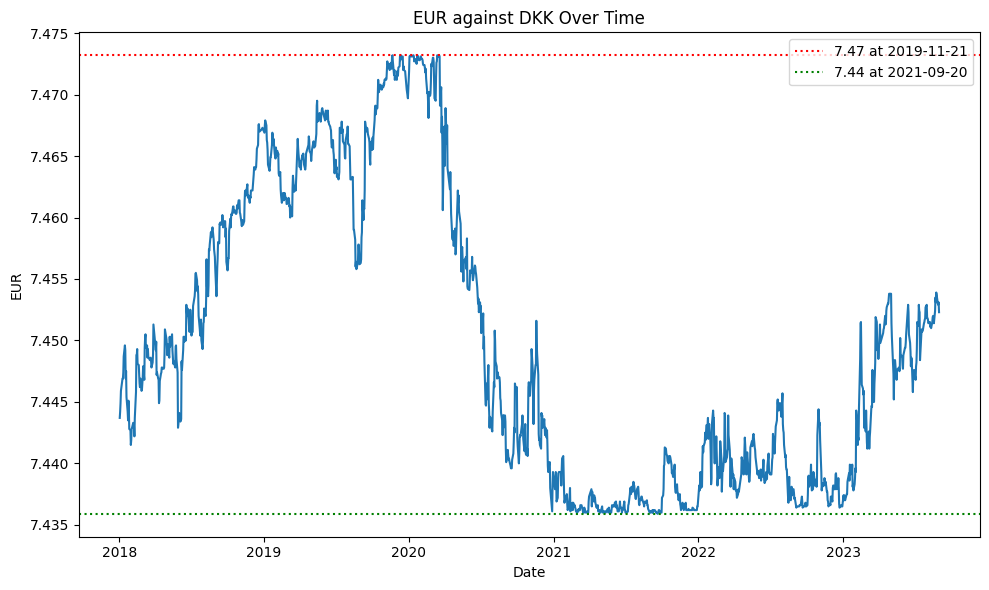

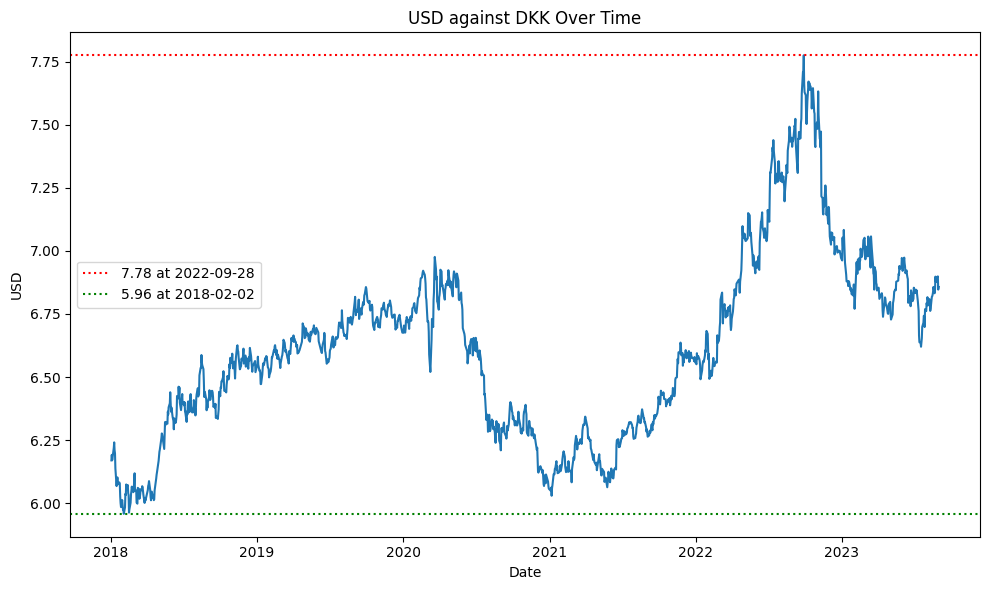

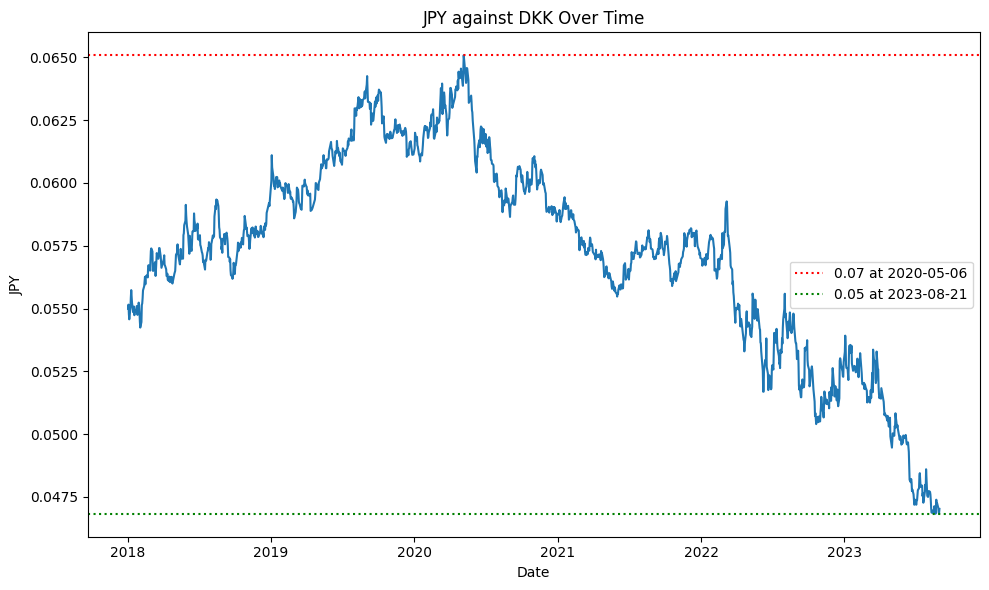

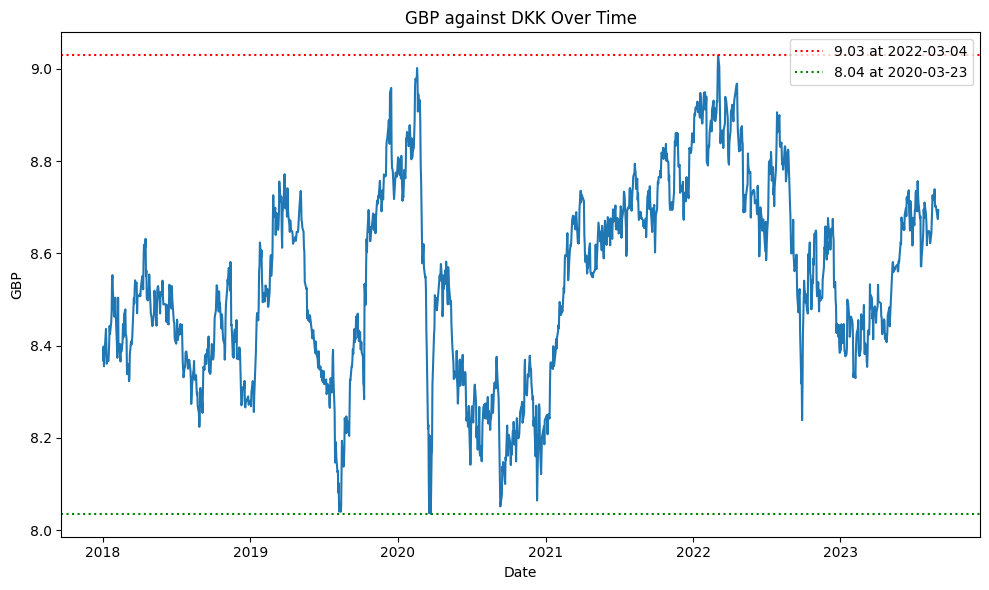

In [5]:
for currency in currencies:
    plot_against_dkk_min_max(currency)

In [15]:
def min_max_appreciation_depreciation_against_dkk_in_a_day(currency: str):

    '''This function will show the biggest appreciation and depreciation in one day -- extreme growth and fall in value. It will give us the exact dates when the
     highest and lowest values were reached'''

    df = all_currencies_dataframe()
    df2 = df[['Date',f'{currency}']]
    df_new = df2.copy()
   
    '''the shift(1) will create a new column, called EUR_shift, that will have the values of the previous day - it will shift the column one record lower. This is 
    in order to calculate the growth and fall in percentage from one day to the other'''

    df_new['col_currency_shift'] = df_new[f'{currency}'].shift(1)
    df_new.dropna(inplace=True)
 
    # df_new['diff'] = (df_new['col_currency_shift']/df_new[f'{currency}']-1)*100
    # same as above, but more readable and nice
    df_new['diff'] = ((df_new[f'{currency}'] - df_new['col_currency_shift']) / df_new['col_currency_shift']) * 100


    # Find the date when the highest and lowest values were achieved. Same 
    max_date = df_new['Date'][df_new['diff'].idxmax()]
    min_date = df_new['Date'][df_new['diff'].idxmin()]
    max_val= df_new['diff'].max()
    min_val = df_new['diff'].min()

    # Create the plot
    fig, ax = plt.subplots()
    plt.plot(df_new['Date'], df_new['diff'])

    # Add markers for the max and min values
    plt.plot(max_date, df_new['diff'].max(), marker='o', markersize=8, label=f"{max_val:.2f} % ({max_date.strftime('%Y-%m-%d')})", linestyle='', color='green')
    plt.plot(min_date, df_new['diff'].min(), marker='o', markersize=8, label=f"{min_val:.2f} % ({min_date.strftime('%Y-%m-%d')})", linestyle='', color='red')

    # Add legend
    plt.legend()

    # Show the plot
    plt.title(f'Biggest appreciation and depreciation of {currency} in a day')
    plt.ylabel('Percentage (%)')
    plt.show()

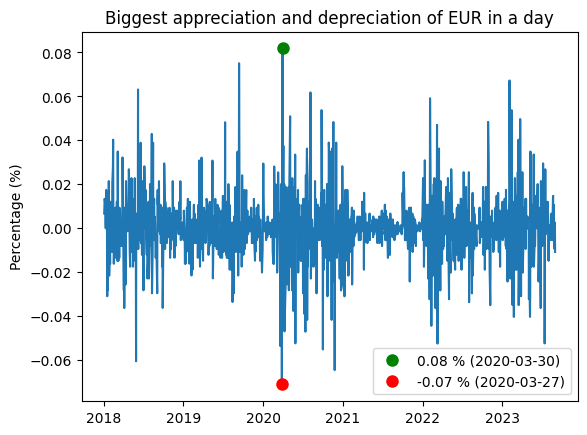

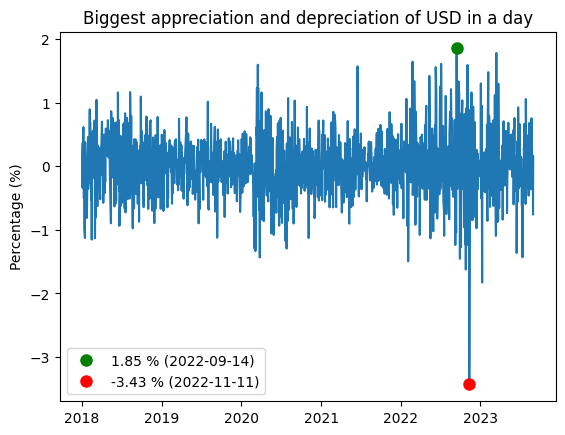

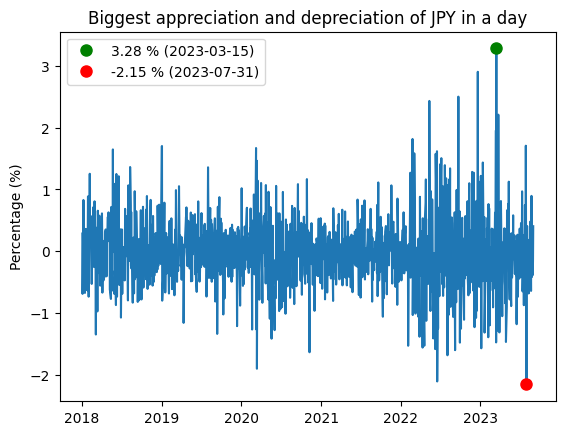

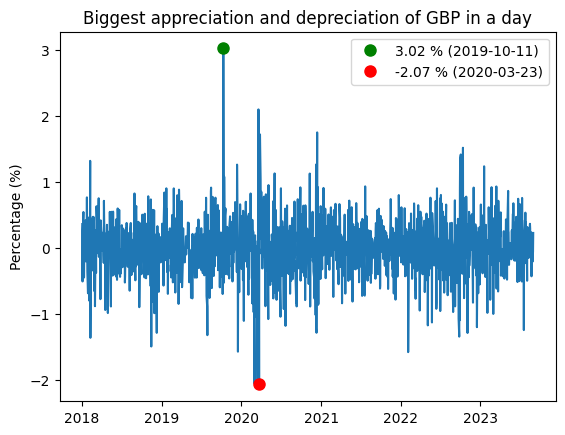

In [16]:
for currency in currencies:
    min_max_appreciation_depreciation_against_dkk_in_a_day(currency)